In [1]:
import torch
import pandas as pd
import os
from tqdm import tqdm
import numpy as np
from PIL import Image
from pathlib import Path
import torchvision
import matplotlib.pyplot as plt
from torchvision import transforms
import sys

### Process raw data and split stuff

In [2]:
# override import path
sys.path.append(os.path.abspath(".."))
from src.machine_override import isic_dir as data_dir  # NOTE: remember to define this!
from src.utils import set_seed

In [3]:
def pdir(loc):
    # patch base file with location
    return os.path.join(data_dir, loc)

In [4]:
gt_df = pd.read_csv(pdir("ISIC_2019_Training_GroundTruth.csv"))
meta_df = pd.read_csv(pdir("ISIC_2019_Training_Metadata.csv"))

In [5]:
data_df = (
    meta_df.merge(gt_df, how="inner", on="image").sample(frac=1).reset_index(drop=True)
)

In [6]:
data_df.set_index("image", inplace=True)

In [7]:
data_df.head()

,age_approx,anatom_site_general,lesion_id,sex,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK
image,,,,,,,,,,,,,
ISIC_0010477,55.0,posterior torso,NaN,female,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ISIC_0060475,45.0,anterior torso,BCN_0003634,female,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ISIC_0057372,40.0,lower extremity,BCN_0002997,female,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ISIC_0027803,70.0,anterior torso,HAM_0002288,male,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ISIC_0028352,55.0,posterior torso,HAM_0006423,male,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
classes = ["MEL", "NV", "BCC", "AK", "BKL", "DF", "VASC", "SCC"]

In [9]:
data = data_df[classes]

In [10]:
# consistent data split
set_seed(42)

# split data into the format of the custom covid dataset
ratio = 0.85

# split data into train and test per class
for c in classes:
    class_data = data[data[c] == 1]
    # get filenames
    files = class_data.index.values
    # split into train and test after shuffling
    np.random.shuffle(files)
    split = int(len(files) * ratio)
    train_files = files[:split]
    test_files = files[split:]

    # create directories
    Path(f"data/train/{c}").mkdir(parents=True, exist_ok=True)
    Path(f"data/test/{c}").mkdir(parents=True, exist_ok=True)

    # copy files
    for f in train_files:
        os.system(f"cp {pdir('ISIC_2019_Training_Input/ISIC_2019_Training_Input')}/{f}.jpg data/train/{c}/{f}.jpg")
    for f in test_files:
        os.system(f"cp {pdir('ISIC_2019_Training_Input/ISIC_2019_Training_Input')}/{f}.jpg data/test/{c}/{f}.jpg")

In [11]:
data.index.values.shape

(25331,)

### Code from previous dataset builder notebook

In [12]:
img_dim = 64
N_rot = 2
N_flip = 2
N_tran = 4
N_scal = 4
N_color = 2

transform_list = []
transform_list.append(transforms.Resize((img_dim * 2, img_dim * 2), interpolation=2))

for i in range(N_color):
    transform_list.append(
        transforms.RandomApply(
            [
                transforms.ColorJitter(
                    brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5
                )
            ],
            p=0.5,
        )
    )

for i in range(N_rot):
    transform_list.append(
        transforms.RandomApply([transforms.RandomRotation(degrees=(-5, 5))], p=0.5)
    )

for i in range(N_flip):
    transform_list.append(transforms.RandomHorizontalFlip(p=0.5))

for i in range(N_scal):
    transform_list.append(
        transforms.RandomApply(
            [transforms.RandomAffine(degrees=0, scale=(0.9, 1.1))], p=0.5
        )
    )

for i in range(N_tran):
    transform_list.append(
        transforms.RandomApply(
            [transforms.RandomAffine(degrees=0, translate=(0.1, 0.1))], p=0.5
        )
    )

transform_list.append(transforms.Resize((img_dim, img_dim), interpolation=2))

transform_list.append(transforms.ToTensor())

transform = transforms.Compose(transform_list)

test_transform = transforms.Compose(
    [
        transforms.Resize((img_dim, img_dim), interpolation=2),
        transforms.ToTensor(),
    ]
)

In [13]:
class MyImageFolder(torchvision.datasets.ImageFolder):
    def __getitem__(self, index):
        return (
            super(MyImageFolder, self).__getitem__(index)[0],
            super(MyImageFolder, self).__getitem__(index)[1],
            self.imgs[index][0],
        )  # return image path

In [14]:
batch_size = 1
data_dir = "data"  # noqa

trainset = MyImageFolder(os.path.join(data_dir, "train/"), transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testset = MyImageFolder(os.path.join(data_dir, "test/"), transform=test_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)
normalset = MyImageFolder(os.path.join(data_dir, "train/"), transform=test_transform)
normalloader = torch.utils.data.DataLoader(
    normalset, batch_size=batch_size, shuffle=False
)

In [15]:
# functions to show an image
def imshow(img):
    # img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

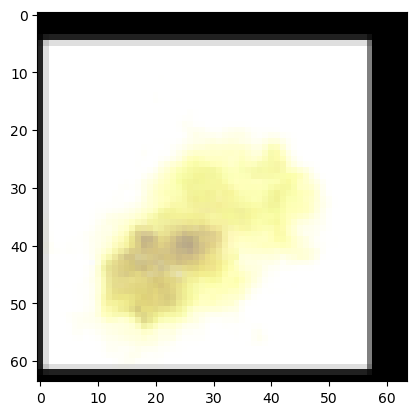

   DF


In [16]:
# get some random training images
for images, labels, path in trainloader:
    break

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(" ".join("%5s" % classes[labels[j]] for j in range(batch_size)))

name, ext = (path[0].split("/")[-1]).rsplit(".", 1)

The point of the following code is to write down the _transformed_ data.

In [17]:
# MAKE FOLDER TEST
for images, labels, path in testloader:
    npimg = np.transpose(images.squeeze(0).numpy(), (1, 2, 0))
    img = Image.fromarray((npimg * 255).astype(np.uint8))
    path = path[0].replace('/test/', '/test_aug/')
    Path(os.path.dirname(path)).mkdir(parents=True, exist_ok=True)
    img.save(path)

In [18]:
# MAKE FOLDER 0
for images, labels, path in normalloader:
    npimg = np.transpose(images.squeeze(0).numpy(), (1, 2, 0))
    img = Image.fromarray((npimg * 255).astype(np.uint8))
    # overwrite
    path = path[0].replace('/train/', '/train_aug/')
    Path(os.path.dirname(path)).mkdir(parents=True, exist_ok=True)
    img.save(path)

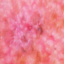

In [19]:
for images, labels, path in normalloader:
    break

npimg = np.transpose(images.squeeze(0).numpy(), (1, 2, 0))
im = Image.fromarray((npimg * 255).astype(np.uint8))
display(im)

In [ ]:
# base training set is 25531 * 0.85 = ~21701 data points,
# and 4k * 8 classes = 32k is the above _rounded up_
sets = [4_000, 8_000, 12_000, 16_000]

class_count = np.zeros((len(classes),), dtype=int) # sequential
for fold_class_size in sets:

    # reset seed because I had to restart the kernel
    set_seed(42)
    
    print("folder start: ", fold_class_size)
    dataiter = iter(trainloader)

    while np.any(class_count < fold_class_size):
        
        # loop back with random
        try:
            images, labels, path = next(dataiter)
        except StopIteration:
            dataiter = iter(trainloader)
            images, labels, path = next(dataiter)

        npimg = np.transpose(images.squeeze(0).numpy(), (1, 2, 0))
        img = Image.fromarray((npimg * 255).astype(np.uint8))

        if class_count[labels[0]] < fold_class_size:
            img_path = path[0].replace("/train/", f"/train_classic/{str(fold_class_size)}/")
            img_dir, img_name = img_path.rsplit("/", 1)
            img_path = img_dir + f"/{fold_class_size}.{class_count[labels[0]]}." + img_name
            # and ensure the folder exists
            Path(img_dir).mkdir(parents=True, exist_ok=True)
            class_count[labels[0]] += 1
            img.save(img_path)

folder start:  4000
